In [47]:
import numpy as np
import matplotlib.pyplot as plt 

import importlib

import components as comp
importlib.reload(comp);

import utils
importlib.reload(utils);

I'm trying to use following parameters:  
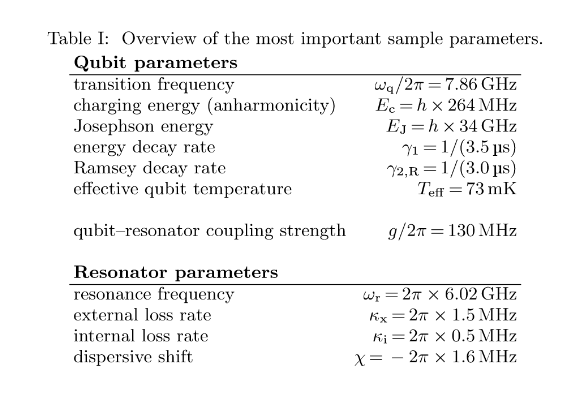

In [48]:
### Parameters
computational_states    = 2
resonator_states        = 20

# System
system = utils.System(dimensions = (resonator_states, computational_states))

# Define the components, which are defined in components.py
# The superconducting qubit
transmon = comp.Transmon(
    n_cutoff        = 11,
    e               = 1.519e6,              # GHz / V
    EJ              = 2 * np.pi * 34,       # GHz hbar
    EJ_EC_ratio     = 128,                  # Gives EC = EJ / ratio
    # gamma           = 2.5                 # EJ2 / EJ1    
)

# Resonator for readout
resonator = comp.Resonator(
    omega           = 2 * np.pi * 6.02,                 # GHz
    n_cutoff        = resonator_states      # States of harmonic oscillator
    
)

# Readout pulse # Jusst for testing - a seperate pulse is defined at every frequency
readout_pulse = comp.ResonatorProbePulse(
    omega       = 2 * np.pi * 6.02,
    duration    = (20, 30),
    rise_time   = 2,
    fall_time   = 2,
    amplitude   = 5 / 6.02 ** 2
)


## Defining Hamiltonians
We can now define the hamiltonians of the system, which sould be these:

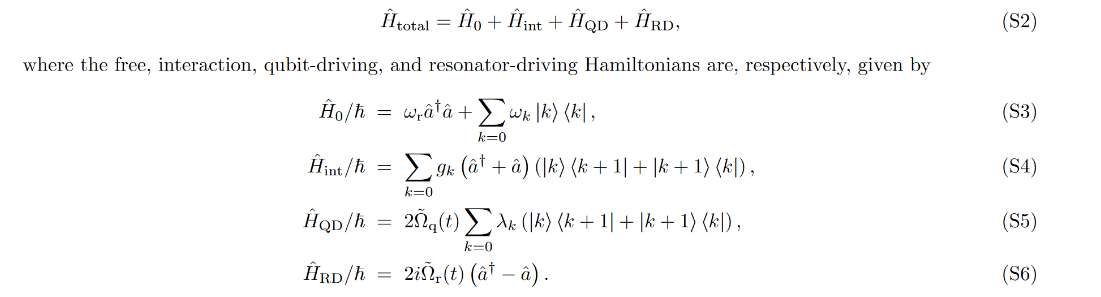

In [49]:
# Find subspace of Transmon
Es, Psis = transmon.eigen_basis(computational_states)   # Get states and energies for transmon
H0_transmon = np.diag(Es)                               # Set E0 = 0


# H0 of the resonator is simply found by:
H0_resonator    = resonator.Hamiltonian().todense()


# We need to define mathematical tools to combine the system
transmon_identity   = np.identity(n = computational_states)
resonator_identity  = np.identity(n = resonator_states)


# Combine the Hamiltonians by tensor product 
H0_transmon_big  = np.kron(resonator_identity,  H0_transmon)
H0_resonator_big = np.kron(H0_resonator,        transmon_identity)

# Sum to get full H0 in 3 x 20 space
H0 = H0_transmon_big + H0_resonator_big


[[ 4.21498625e-15 -1.39106622e+00]
 [-1.39106622e+00 -5.16172111e-15]]


/tmp/ipykernel_446/326297435.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H_with_interaction))
/tmp/ipykernel_446/326297435.py:21: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(H_with_interaction))


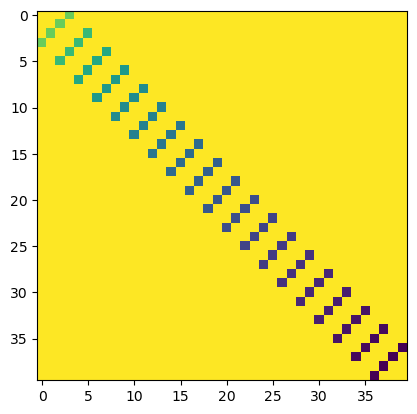

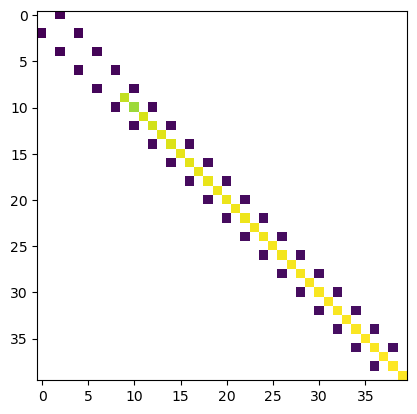

In [50]:
# Overlap
H_overlap_n = Psis.conj().T @ transmon.n_matrix() @ Psis

print(H_overlap_n)

# This is the rotating wave approximation.
# H_q_to_r = np.kron(resonator.a_dagger().todense(), np.triu(transmon_identity))
# H_r_to_q = np.kron(resonator.a().todense(),        np.tril(transmon_identity))
# H_int = H_q_to_r + H_r_to_q
# 

# This should be exact
H_int = np.kron((resonator.a_dagger() + resonator.a()).todense(), H_overlap_n)
plt.imshow(H_int)

plt.figure()
interaction_strength = 2 * np.pi * 0.130 # GHz / 2 pi  
# interaction_strength *= 1 

H_with_interaction = H0 + interaction_strength *  H_int
plt.imshow(np.log(H_with_interaction))

## Readout Drive

In [51]:

# Define Hamilton with given frequency
def get_Hamiltonian(omega):
    # Define the resonator given a pulse frequency
    readout_pulse = comp.ResonatorProbePulse(
        omega       = omega,
        duration    = (0, 50),
        rise_time   = 0,
        fall_time   = 0,
        amplitude   = 1 / 10
    )

    # Get pulse and the Unitary transformation opposite to the pulse
    pulse_on_resonator = readout_pulse.output()
    
    def Hamiltonian(t):
        constant_H = H_with_interaction

        # Define the pules and hamiltonian interacting with the resonator
        total_pulse = pulse_on_resonator[0](t) + pulse_on_resonator[1](t) 
        H_reso      = 2j *  total_pulse * (resonator.a_dagger() - resonator.a())
        H_reso_hilbert_space = np.kron(H_reso.todense(), transmon_identity)

        return constant_H + H_reso_hilbert_space

    return Hamiltonian


def master_equation(t, y, hamiltonian, U, Udot_inner = 0):
    # Get the hamiltonian and the unitary transformation
    H = hamiltonian(t)
    U = U(t)

    H_rotating = U @ H @ U.conj().T + 1j * U @ Udot_inner @ U.conj().T

    rho = y.reshape((system.dimensions[0] * system.dimensions[1], system.dimensions[0] * system.dimensions[1]))

    # Calculate the derivative of the density matrix
    d_rho = -1j * (H_rotating @ rho - rho @ H_rotating)

    return d_rho.flatten()

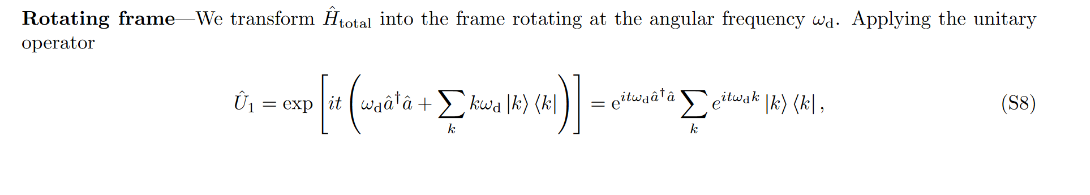

In [52]:
from scipy.linalg import expm
def get_rotating_frame(frequency):
    n = np.kron(resonator.n_matrix().todense(), transmon_identity)
    k = np.kron(resonator_identity,             np.diag(np.arange(computational_states)))
    def U(t):
        return expm(1j * frequency * (n + k) * t)

    U_dot_inner = 1j * frequency * (n + k)

    return U, U_dot_inner

    ## Following is a dummy function, which does not transform the hamiltonian
    # def dummy(t):
    #     return np.eye(system.hilbert_size)

    # return dummy, np.zeros_like(U_dot_inner) # This is no transformation
 
    



In [53]:
# Define the first excited state of the resonator
resonator_g = np.zeros(resonator_states, dtype = np.complex128)
resonator_g[0] = 1

# Define ground state of transmon
transmon_g = np.array((1, 0), dtype = np.complex128)
transmon_e = np.array((0, 1), dtype = np.complex128)

# Define initial density matrix
initial_state_g = np.kron(resonator_g, transmon_g)
initial_density_matrix_g = np.outer(initial_state_g, initial_state_g.conj())

initial_state_e = np.kron(resonator_g, transmon_e)
initial_density_matrix_e = np.outer(initial_state_e, initial_state_e.conj())

In [54]:
initial_state_g

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [56]:
from numba import prange
from tqdm import tqdm
from scipy.integrate import solve_ivp

# Define the frequencies to test
omegas_to_test = 2 * np.pi * np.linspace(5.92, 6.12, 21)

# Duration of Simulation
duration = (0, 50)


def simulate(omegas, initial_state):
    results = []

    for i in tqdm(range(len(omegas_to_test))):
        omega = omegas_to_test[i]
        
        H = get_Hamiltonian(omega)

        U, Udot_inner = get_rotating_frame(omega)
        
        sol = solve_ivp(master_equation, duration, initial_state.flatten(), args = (H, U, Udot_inner), method = 'RK45')

        results.append(sol)

    return results

print("Simulating ground state")
results_g = simulate(omegas_to_test, initial_density_matrix_g)

print("Simulating excited state")
results_e = simulate(omegas_to_test, initial_density_matrix_e)

Simulating ground state


100%|██████████| 21/21 [04:05<00:00, 11.70s/it]


Simulating excited state


100%|██████████| 21/21 [03:24<00:00,  9.74s/it]


In [57]:
from scipy.special import factorial

def Q_function(density_matrix, n_cutoff = resonator_states, resolution = 20):
    xs = ys = np.linspace(-n_cutoff, n_cutoff, resolution)
    xs, ys = np.meshgrid(xs, ys)

    # Calculate alphas
    alphas = xs + 1j * ys
    alphas = alphas.flatten()

    # Noramlization
    normalization = np.exp(- alphas * alphas.conj() / 2)

    # Basis change
    ns = np.expand_dims(np.arange(n_cutoff), 1)
    P  = normalization * np.power(alphas, ns) / np.sqrt(factorial(ns))

    return np.diag(P.conj().T @ density_matrix @ P).reshape((resolution, resolution))


In [58]:
def plot_Q(time, frequency_choice = 0, resolution = 100):
    sol_e = results_e[frequency_choice].y.reshape(system.hilbert_size, system.hilbert_size, -1)
    sol_g = results_g[frequency_choice].y.reshape(system.hilbert_size, system.hilbert_size, -1)

    reso_e  = system.partial_trace(sol_e[:, :, time], 1)
    reso_g  = system.partial_trace(sol_g[:, :, time], 1)

    # Get the Q function
    Q_e = Q_function(reso_e, resolution=resolution)
    Q_g = Q_function(reso_g, resolution=resolution)

    # Plot the Q function
    plt.imshow(abs(Q_e), cmap = "Blues", alpha = .5)
    plt.imshow(abs(Q_g), cmap = "Reds", alpha = .5)

    plt.hlines(resolution / 2, 0, resolution, linestyles = "dashed", color = "black")
    plt.vlines(resolution / 2, 0, resolution, linestyles = "dashed", color = "black")

from ipywidgets import interact
interact(plot_Q, time = (0, results_g[0].y.shape[1] - 1, 1), frequency_choice = (0, len(omegas_to_test) - 1, 1))

interactive(children=(IntSlider(value=553, description='time', max=1107), IntSlider(value=0, description='freq…

<function __main__.plot_Q(time, frequency_choice=0, resolution=100)>

In [59]:
dims = np.prod(system.dimensions)
def get_expectation_occupation(results):
    rhos = [ds.y.reshape(system.hilbert_size, system.hilbert_size, -1) for ds in results]
    last_rho = [rho[:, :, -1] for rho in rhos]
    last_rho_reso = [system.partial_trace(rho, trace_over = 1) for rho in last_rho]
    last_exp_n    = [np.trace(rho @ resonator.n_matrix()) for rho in last_rho_reso]

    return last_exp_n

exp_n_g = get_expectation_occupation(results_g)
exp_n_e = get_expectation_occupation(results_e)


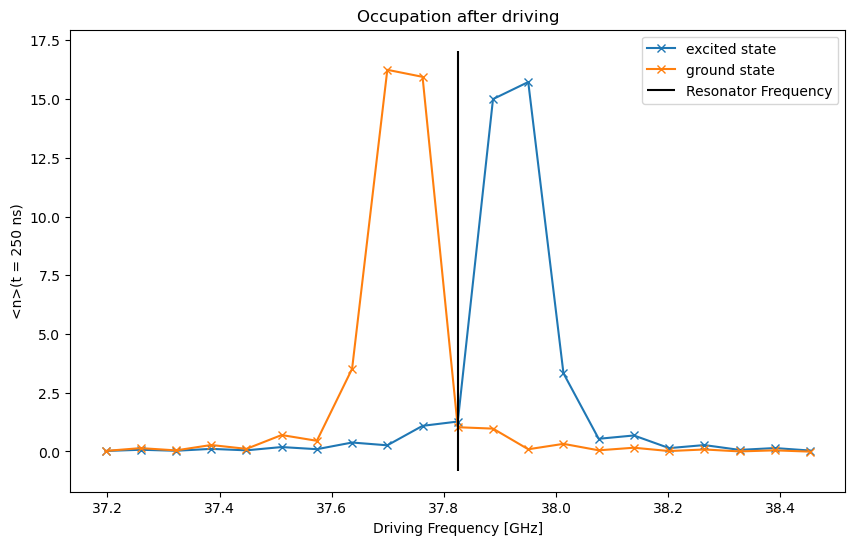

In [60]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(omegas_to_test, exp_n_e, marker = "x", label = "excited state")
ax.plot(omegas_to_test, exp_n_g, marker = "x", label = "ground state")

ax.vlines(2 * np.pi * 6.02, *ax.get_ylim(), color = "k", label = "Resonator Frequency")

ax.set(
    xlabel = "Driving Frequency [GHz]",
    ylabel = "<n>(t = 50 ns)",
    title = "Occupation after driving"
)

ax.legend()